In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from xgboost import XGBRegressor
from sklearn import metrics



In [84]:
df = pd.read_csv("../ready_data/winters_merged.csv")

In [85]:
model = XGBRegressor()
model.load_model("xgb_best.json")

In [86]:
def calculate_forecast(df, columns):
    for col in columns:
        df[f"fcst_{col}"] = df[col][::-1].rolling(window=12, min_periods=1).mean()[::-1]
    return df

def calculate_avg_past(df, columns):
    for col in columns:
        df[f"past4h_avg_{col}"] = df[col].rolling(window=24, min_periods=1).mean()
    return df

def add_target(df):
    df['friction_fcst'] = df['Friction'].shift(periods=-12)
    df = df.dropna()
    return df

In [87]:
past4h_avg_columns = ['airTemp', 'humidity', 'dewpoint', 'precipitation', 'Friction',
       'Road_Surface_Temperature', 'Water_Film_Surface_mm']

forecast_columns = ['airTemp', 'humidity', 'dewpoint', 'precipitation']

In [88]:
# Pick date or use random day
# convert to datetime
df['ts'] = pd.to_datetime(df['ts'])
# make a copy of original df
grouped_df = df
# group timesteps by date
grouped_df["date"] = grouped_df['ts'].dt.date
unique_days = grouped_df['date'].unique()
# randomly select date
selected_day = random.choice(unique_days)

selected_df = grouped_df[grouped_df['date'] == selected_day]

# Step 5: Drop the temporary `date` column
selected_df = selected_df.drop(columns=['date'])
selected_df

,ts,airTemp,humidity,dewpoint,precipitation,Friction,Road_Surface_Temperature,Water_Film_Surface_mm
8208,2021-12-28 00:00:00,-8.7,96.0,-9.30,0.0,0.512719,-9.430778,0.057279
8209,2021-12-28 00:10:00,-8.8,95.0,-9.40,0.0,0.512832,-9.236199,0.057830
8210,2021-12-28 00:20:00,-8.9,96.0,-9.40,0.0,0.512733,-9.503143,0.057063
8211,2021-12-28 00:30:00,-8.9,96.0,-9.40,0.0,0.514329,-9.394384,0.056985
8212,2021-12-28 00:40:00,-9.0,97.0,-9.40,0.0,0.509828,-9.690955,0.057236
...,...,...,...,...,...,...,...,...
8347,2021-12-28 23:10:00,-4.9,93.0,-5.80,0.0,0.516932,-6.918884,0.064583
8348,2021-12-28 23:20:00,-5.0,93.0,-5.90,0.0,0.515282,-6.998590,0.064746
8349,2021-12-28 23:30:00,-5.3,93.0,-6.20,0.0,0.512396,-7.175843,0.064890
8350,2021-12-28 23:40:00,-5.3,93.0,-6.20,0.0,0.513555,-7.180724,0.064545


In [89]:
# preprocess data
selected_df = calculate_forecast(selected_df, forecast_columns)
selected_df = calculate_avg_past(selected_df, past4h_avg_columns)



In [90]:
predictions = model.predict(selected_df.drop("ts", axis=1))
predictions = pd.DataFrame(predictions, columns=["friction_fcst"])
predictions = predictions["friction_fcst"].shift(12)
predictions

0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
139    0.523238
140    0.515495
141    0.515848
142    0.514950
143    0.513017
Name: friction_fcst, Length: 144, dtype: float32

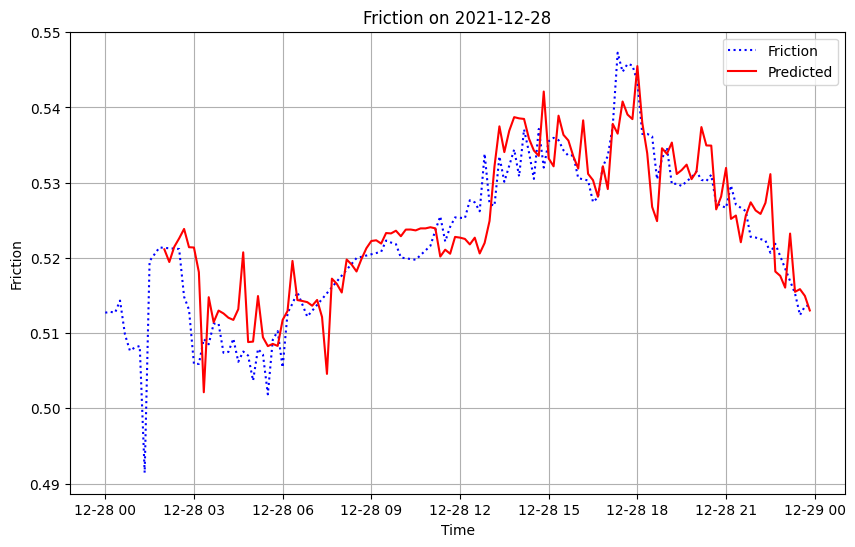

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(selected_df.ts, selected_df['Friction'], label="Friction", color='b', linestyle=":")
plt.plot(selected_df.ts, predictions, label="Predicted", color='r')
plt.title(f'Friction on {selected_day}')
plt.xlabel('Time')
plt.ylabel('Friction')
plt.legend()
plt.grid(True) 
plt.show()